In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import random
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('datafile.csv')

In [3]:
df.head()

name            imagepath
0     0  imagesok/000002.jpg
1     0  imagesok/000003.jpg
2     0  imagesok/000004.jpg
3     0  imagesok/000005.jpg
4     0  imagesok/000006.jpg

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['name'], random_state=42)

In [5]:
def calculate_rois_and_draw(image_path, max_rois=5, min_area=5000):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rois = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        if area >= min_area:
            rois.append((x, y, w, h))

    rois = sorted(rois, key=lambda roi: roi[2] * roi[3], reverse=True)[:max_rois]
    
    for (x, y, w, h) in rois:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return image



In [6]:
# Store processed images for visualization
def process_images(df):
    processed_images = []
    for index, row in df.iterrows():
        image_path = row['imagepath']
        print(f"Processing image: {image_path}")
        
        processed_image = calculate_rois_and_draw(image_path)
        if processed_image is not None:
            processed_images.append(processed_image)
    return processed_images

In [7]:
train_images = process_images(train_df)
test_images = process_images(test_df)

Processing image: imagesok/000838.jpg
Processing image: imagesok/000967.jpg
Processing image: imagesok/001854.jpg
Processing image: imagesnotok/003050.jpg
Processing image: imagesok/000109.jpg
Processing image: imagesok/002402.jpg
Processing image: imagesnotok/003228.jpg
Processing image: imagesnotok/003105.jpg
Processing image: imagesok/002579.jpg
Processing image: imagesok/002166.jpg
Processing image: imagesok/001096.jpg
Processing image: imagesok/002015.jpg
Processing image: imagesok/000280.jpg
Processing image: imagesnotok/002729.jpg
Processing image: imagesnotok/003306.jpg
Processing image: imagesnotok/003371.jpg
Processing image: imagesok/000041.jpg
Processing image: imagesnotok/002915.jpg
Processing image: imagesok/000146.jpg
Processing image: imagesok/002587.jpg
Processing image: imagesok/000495.jpg
Processing image: imagesok/002417.jpg
Processing image: imagesok/002017.jpg
Processing image: imagesnotok/003518.jpg
Processing image: imagesok/002424.jpg
Processing image: imagesno

In [8]:
random_train_images = random.sample(train_images, min(100, len(train_images)))

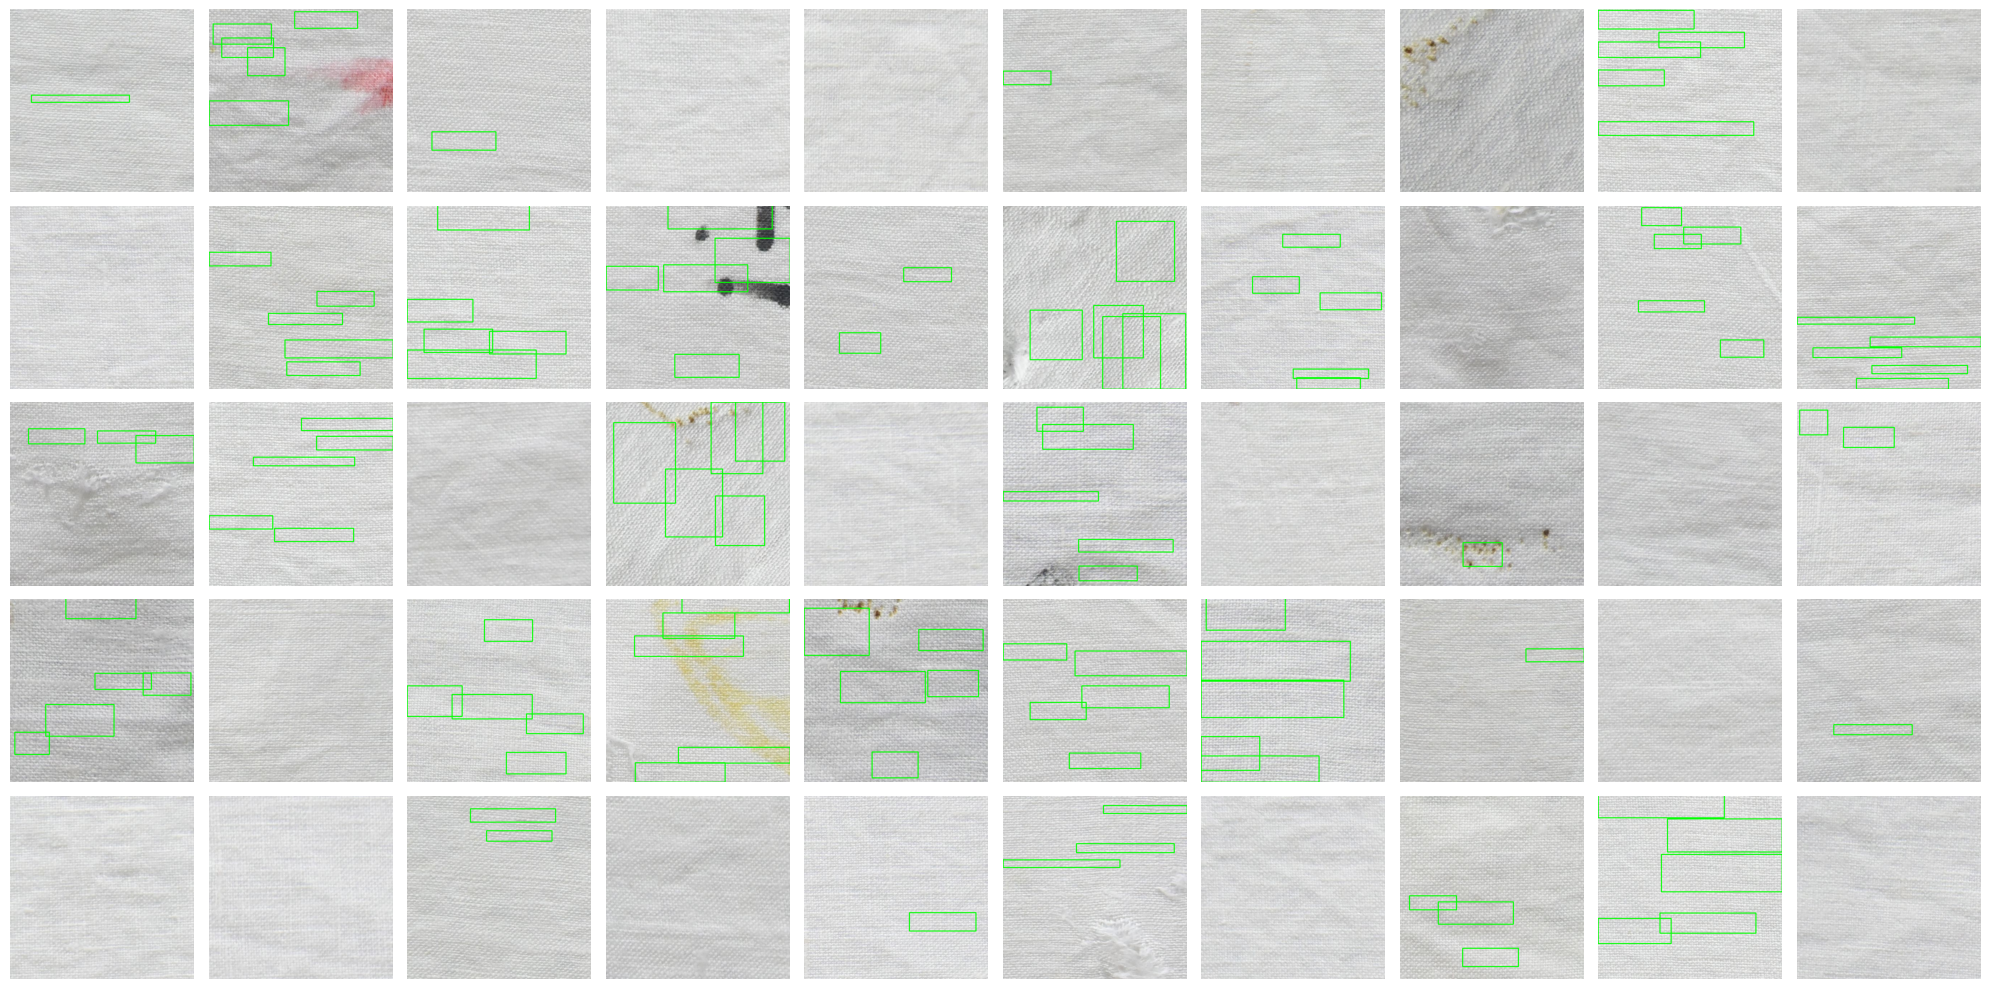

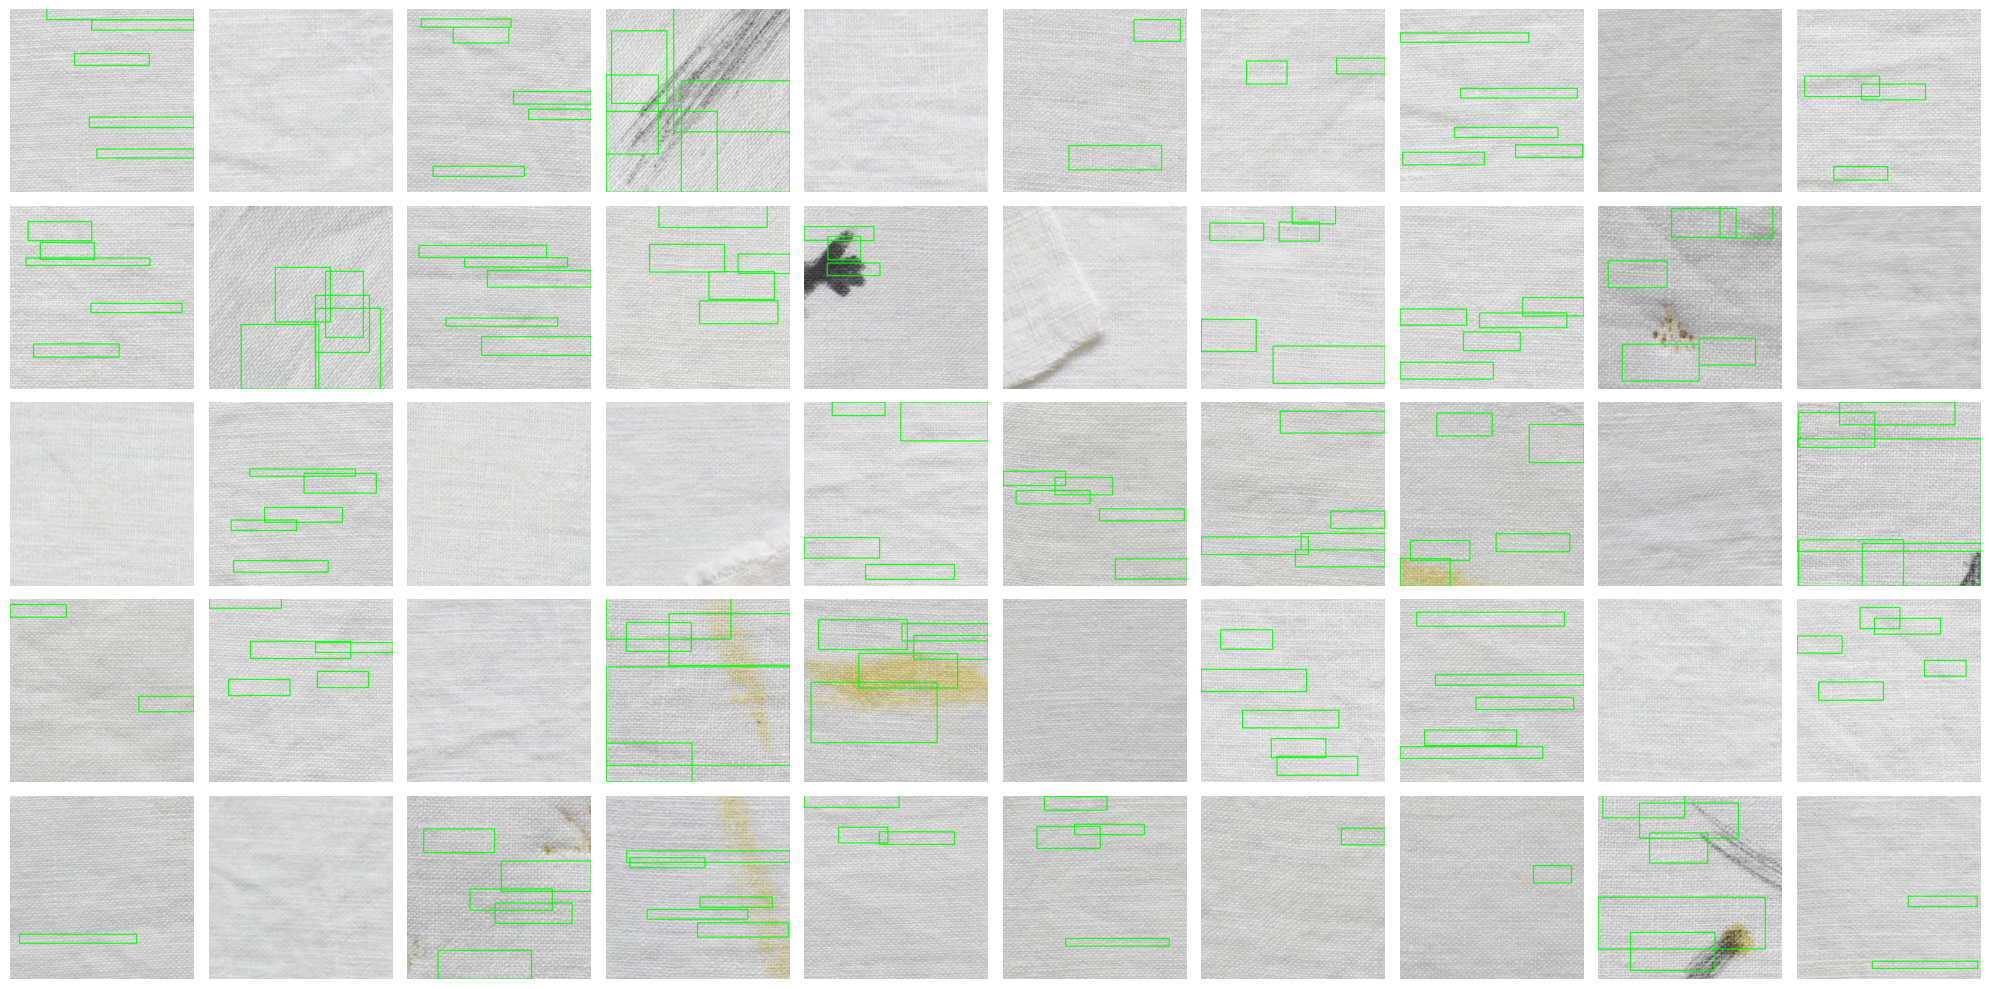

In [9]:
def visualize_images(images, batch_size=50):
    num_batches = len(images) // batch_size
    for batch in range(num_batches):
        # Create a grid for the batch
        fig, axes = plt.subplots(5, 10, figsize=(20, 10))  # 5 rows, 10 columns
        axes = axes.ravel()

        # Plot each image in the grid
        for i in range(batch_size):
            image = images[batch * batch_size + i]
            axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axes[i].axis('off')  # Hide axis for clean view

        plt.tight_layout()
        plt.show()

# Visualize in batches of 50 images with bounding boxes
visualize_images(random_train_images[:50])  # First 50 images
visualize_images(random_train_images[50:])  # Second 50 images

In [10]:
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

print("Train-test split completed and datasets saved.")

Train-test split completed and datasets saved.


In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [33]:
class CustomImageDataset(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=16, image_size=(300, 300), shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.dataframe))
        self.on_epoch_end()
        
        # Data Augmentation
        self.datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.dataframe.iloc[indices]
        
        images, labels = self.__data_generation(batch_data)
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_data):
        images = []
        labels = []
        for _, row in batch_data.iterrows():
            img_path = row['imagepath']
            image = tf.keras.preprocessing.image.load_img(img_path, target_size=self.image_size)
            image = tf.keras.preprocessing.image.img_to_array(image) / 255.0  # Normalize to [0, 1]
            image = np.expand_dims(image, axis=0)  # Add a batch dimension

            # Apply data augmentation
            augmented_images = next(self.datagen.flow(image, batch_size=1))
            images.append(augmented_images[0])  # Append the augmented image
            labels.append(row['name'])
        
        return np.array(images), np.array(labels)


In [34]:
train_dataset = CustomImageDataset(train_df, batch_size=16, image_size=(300, 300))
test_dataset = CustomImageDataset(test_df, batch_size=16, image_size=(300, 300))


In [35]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))


In [36]:
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 classes: good and tampered images
])

In [41]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    # Reduce the learning rate by a factor of 0.5 every 5 epochs
    if epoch > 0 and epoch % 5 == 0:
        return lr * 0.5
    return lr

# Create the Learning Rate Scheduler callback
lr_callback = LearningRateScheduler(lr_scheduler)

In [42]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


In [43]:
from tensorflow.keras.optimizers import Adam

# Set an initial learning rate
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [44]:
num_epochs = 10  # Adjust as necessary
# Train the model with the callbacks
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    callbacks=[lr_callback, reduce_lr]
)


Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 655s 4s/step - accuracy: 0.8278 - loss: 0.5347 - val_accuracy: 0.2500 - val_loss: 3465.9353 - learning_rate: 0.0010
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 633s 4s/step - accuracy: 0.8766 - loss: 0.3304 - val_accuracy: 0.7486 - val_loss: 0.6820 - learning_rate: 0.0010
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 628s 4s/step - accuracy: 0.9113 - loss: 0.2777 - val_accuracy: 0.7486 - val_loss: 0.6710 - learning_rate: 0.0010
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 628s 4s/step - accuracy: 0.9243 - loss: 0.2151 - val_accuracy: 0.7528 - val_loss: 0.6594 - learning_rate: 0.0010
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 628s 4s/step - accuracy: 0.9096 - loss: 0.2958 - val_accuracy: 0.7472 - val_loss: 0.6604 - learning_rate: 0.0010
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 630s 4s/step - accuracy: 0.9450 - loss: 0.1633 - val_accuracy: 0.7884 - val_loss: 0.6415 - learning_rate: 5.0000e-04
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 629s 4s/step - accuracy: 0.9516 - l

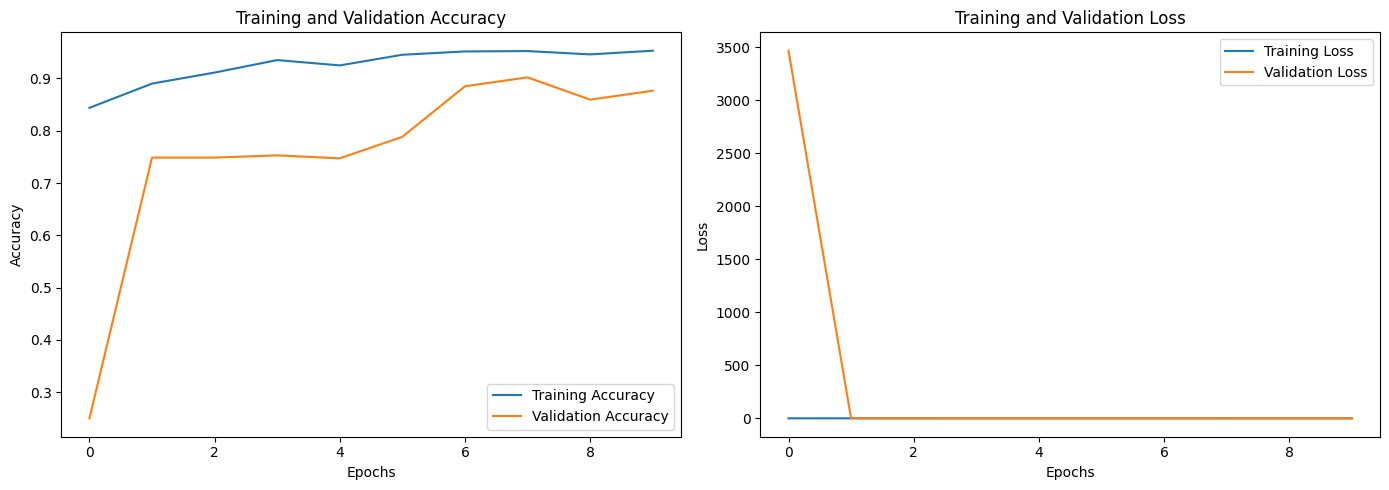

In [45]:
def plot_training_history(history):
    # Plot Training & Validation Accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

In [50]:
import os
testset_folder = 'testset'  # Update this with the actual path to the folder

# Image size expected by the model
image_size = (300, 300)

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, image_size):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Variables to store results
total_images = 0
correct_predictions = 0

# Loop through each image file in the testset folder
for image_file in os.listdir(testset_folder):
    # Full path of the image
    image_path = os.path.join(testset_folder, image_file)

    # Check if the file is an image
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Preprocess the image
        image = load_and_preprocess_image(image_path, image_size)

        # Make prediction
        prediction = model.predict(image)
        predicted_label = np.argmax(prediction)  # Get the predicted class (0 or 1)

        # Print the file name and predicted label
        print(f"Image: {image_file}, Predicted Label: {predicted_label}")

        total_images += 1

# Print the total number of images processed
print(f"Total Images Tested: {total_images}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Image: damaged.jpg, Predicted Label: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Image: good.jpg, Predicted Label: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Image: wrinkled.jpg, Predicted Label: 0
Total Images Tested: 3
